# CHAPTER 03. 평가

- 이진 분류 에서의 평가 지표
    - 정확도 보다는 다른 성능 평가 지표가 더 중요시되는 경우가 많다.
    - 성능 평가 지표의 종류
        - 정확도(Accuracy)
        - 오차행렬(Confusion Matrix)
        - 정밀도(Precision)
        - 재현율(Recall)
        - F1 스코어
        - ROC AUC
        
    

## 01. 정확도(Accuracy)

- 정확도 = 맞게 예측한 수 / 전체 예측 데이터 수
- 불균형한 레이블 분포를 가진 데이터 셋에서 예측 값이 한 값으로 고정된 에스티메이터를 사용하면 높은 정확도가 나올 수 있는 점에서 불균형 분포를 가진 데이터셋의 이진분류 에스티메이터의 성능을 평가하는 지표로서 정확도는 적절하지 못함.



In [1]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class myDummyClassifier(BaseEstimator):
    def predict(self, X):
        pred = np.zeros((X.shape[0], 1))
        for i in range (X.shape[0]):
            if X["Sex"].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1
        return pred

def fillna(df):
    df["Age"].fillna(df["Age"].mean(), inplace=True)
    df["Cabin"].fillna("N", inplace=True)
    df["Embarked"].fillna("N", inplace=True)
    df["Fare"].fillna(0, inplace=True)
    return df

def drop_features(df):
    df.drop(["PassengerId", "Name", "Ticket"], axis = 1, inplace = True)
    return df

def format_features(df):
    df["Cabin"] = df["Cabin"].str[:1]
    features = ["Cabin", "Sex", "Embarked"]
    for f in features:
        encoder = LabelEncoder()
        encoder = encoder.fit(df[f])
        df[f] = encoder.transform(df[f])
    return df

def preprocessing(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

titanic_df = pd.read_csv("../data/titanic_train.csv")
Y_titanic_df = titanic_df["Survived"]
X_titanic_df = titanic_df.drop("Survived", axis = 1)

X_titanic_df = preprocessing(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, Y_titanic_df, test_size = 0.2, random_state = 0)

myclf = myDummyClassifier()
pred = myclf.predict(X_test)

print(accuracy_score(y_test, pred))


0.7877094972067039


## 02. 오차 행렬

<pre>
[[TN, FP]
 [FN, TP]]
</pre>

- True : 맞춤, False: 틀림, Positive: 1 예상, Negative: 0 예상
- 정확도 = TN + TP / TN + FP + FN + TP (맞춘거 / 전체)
- 불균형한 레이블 클래스를 가지는 이진 분류 데이터에서 중점적으로 찾아야하고 수가 적은 레이블이 보통 postivie(1) 로 설정


In [2]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, pred)

array([[92, 18],
       [20, 49]])

## 03. 정밀도와 재현율

- 정밀도(Precision) = TP / FP + TP 
    - Positive 라고 예상한 경우에서 실제 Positive 였던 경우
    - FN 가 낮은 정도
    - FN 이 치명적일 경우 높을 수록 좋음 ex. P: 암 양성, FN: 암환자 음성으로 판단
- 재현율(Recall) = TP / FN + TP 
    - 실제 Positive 인 경우 중 Positive 라고 예상한 경우의 수
    - FP 가 낮은 정도
    - FP 가 치명적일 경우 높을 수록 좋음 ex. P: 스팸메일임, FP 하면 일반메일 못읽음) 
- 정밀도와 재현율 모두 1 에 가까울 수록 좋지만, FN, FP 중 치명적인 경우에 따라 평가 지표의 중요성이 달라짐.


In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.linear_model import LogisticRegression


def get_clf_eval(y_test, pred):
    print("confusion matrix")
    print(confusion_matrix(y_test, pred))
    print("accuracy, precision, recall")
    print(accuracy_score(y_test, pred), precision_score(y_test, pred), recall_score(y_test, pred))

get_clf_eval(y_test, pred) # dummy classifier

lrclf = LogisticRegression()
lrclf.fit(X_train, y_train)
lr_pred = lrclf.predict(X_test)

get_clf_eval(y_test, lr_pred)



confusion matrix
[[92 18]
 [20 49]]
accuracy, precision, recall
0.7877094972067039 0.7313432835820896 0.7101449275362319
confusion matrix
[[92 18]
 [16 53]]
accuracy, precision, recall
0.8100558659217877 0.7464788732394366 0.7681159420289855


### 정밀도/재현율 트레이드오프

- 정밀도 재현율 서로 상호보완적인 관계라 하나 높이면 하나 떨어짐
- threshold 값을 정하여 positive 예측 확률을 높일 수 있음
- precision_recall_curve() : threshold 값에 따른 재현율, 정밀도를 파악할 수 있어서 적절한 threshold 를 찾을 수 있음


In [4]:
lrclf.predict_proba(X_test)
np.concatenate([lrclf.predict_proba(X_test), lr_pred.reshape(-1, 1)], axis = 1)[:6]


array([[0.85136392, 0.14863608, 0.        ],
       [0.89242559, 0.10757441, 0.        ],
       [0.93366231, 0.06633769, 0.        ],
       [0.05371121, 0.94628879, 1.        ],
       [0.31288254, 0.68711746, 1.        ],
       [0.49123013, 0.50876987, 1.        ]])

In [5]:
from sklearn.preprocessing import Binarizer

binarizer_sample = [[1,2],[3,4],[5,6]]
binarizer = Binarizer(threshold = 4)
binarizer.fit_transform(binarizer_sample)


array([[0, 0],
       [0, 0],
       [1, 1]])

In [6]:
custom_threshold = .9 # threshold 높음 -> positive 확률 줄어듬 -> 정밀도 높아짐
pred_proba = lrclf.predict_proba(X_test)[:,1].reshape(-1, 1) # predict proba 에서 positive 열만 추출, ㄹ리쉐잎
binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba)
custom_pred = binarizer.transform(pred_proba)
get_clf_eval(y_test, custom_pred)


confusion matrix
[[110   0]
 [ 51  18]]
accuracy, precision, recall
0.7150837988826816 1.0 0.2608695652173913


In [7]:
from sklearn.metrics import precision_recall_curve

from sklearn.metrics import precision_recall_curve

pred_proba_class_1 = lrclf.predict_proba(X_test)[:, 1] #1열

precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class_1)

threshindexes = np.arange(0, thresholds.shape[0], 15)
print("threshholds, precisions, recalls")
print(np.concatenate([thresholds[threshindexes].reshape(-1,1),precisions[threshindexes].reshape(-1,1),recalls[threshindexes].reshape(-1,1)], axis=1)) # 해당 인덱스에 따른 임계값, 정밀도, 재현율 합쳐서 출력.



threshholds, precisions, recalls
[[0.05934342 0.39884393 1.        ]
 [0.09628969 0.41772152 0.95652174]
 [0.11504039 0.46376812 0.92753623]
 [0.14863608 0.5203252  0.92753623]
 [0.19189531 0.59433962 0.91304348]
 [0.28086099 0.65934066 0.86956522]
 [0.43349912 0.72368421 0.79710145]
 [0.57233034 0.80327869 0.71014493]
 [0.64848614 0.82608696 0.55072464]
 [0.79852043 1.         0.44927536]
 [0.91268108 1.         0.23188406]
 [0.96843611 1.         0.01449275]]


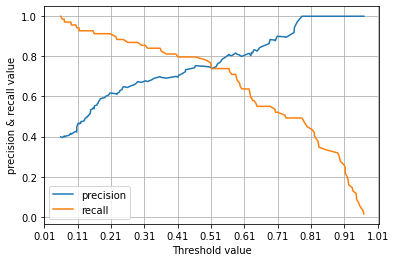

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_class1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
    plt.plot(thresholds, precisions[:thresholds.shape[0]], label="precision")
    plt.plot(thresholds, recalls[:thresholds.shape[0]], label = "recall")

    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel("Threshold value")
    plt.ylabel("precision & recall value")
    plt.legend()
    plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, lrclf.predict_proba(X_test)[:,1]) #위의 표에서 처럼 0.4, 0.6 사이에서 같아짐

### 정밀도와 재현율의 맹점

- 확실한 기준일 때만 positive 예측 -> 정밀도 100%
- 모두 positive 로 예측 -> 재현율 100%
- 하나만 높이려기 보다는 둘다 적절히 높은게 좋다.


## 04. F1 스코어

- 정밀도, 재현율 중 한 쪽으로 치우치지 않을 때 높음



In [9]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, lr_pred)
print(f1)

0.7571428571428571


In [10]:
def get_clf_eval2(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    print("confusion matrix")
    print(confusion)
    print("{0:.4f},{1:.4f},{2:.4f}, {3:.4f}".format(accuracy, precision, recall, f1))

thresholds = [.4, .45, .5, .55, .6]
pred_proba = lrclf.predict_proba(X_test)
get_clf_eval2(y_test, lr_pred)

confusion matrix
[[92 18]
 [16 53]]
0.8101,0.7465,0.7681, 0.7571


### ROC 곡선과 AUC

- Receiver Operation Characteristic Curve
- 민감도(True Positive Rate(TPR)) : 실제값인 Positive 가 정확히 예측돼야 하는 수준
- 특이성(True Negative Rate(TNR)): 실제값인 Negative 가 정확히 예측돼야 하는 수준
    - TN / (FP + TN)
- FPR 
    - FP/ (FP + TN)  ( 1 - TNR(특이성))


In [11]:
from sklearn.metrics import roc_curve

fprs, tprs, thresholds = roc_curve(y_test, lrclf.predict_proba(X_test)[:, 1])

thr_index = np.arange(1, thresholds.shape[0], 5)
print(thr_index)
print(np.round(thresholds[thr_index], 3)) 
print(np.round(fprs[thr_index],3))
print(np.round(tprs[thr_index], 3))

# fpr 이 증가함에따라 tpr 이 가파르게 증가해야 좋음


[ 1  6 11 16 21 26 31 36 41 46 51]
[0.968 0.687 0.629 0.564 0.376 0.29  0.16  0.149 0.108 0.09  0.029]
[0.    0.045 0.091 0.109 0.227 0.264 0.464 0.527 0.736 0.855 1.   ]
[0.014 0.551 0.594 0.739 0.812 0.87  0.913 0.928 0.942 0.971 1.   ]


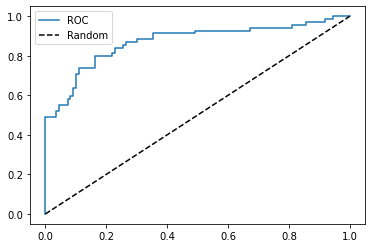

In [12]:
def roc_curve_plot(y_test, pred_proba_c1):
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    plt.plot(fprs, tprs, label="ROC")
    plt.plot([0,1],[0,1],"k--", label = "Random")
    plt.legend()

roc_curve_plot(y_test, pred_proba_class_1)

- Area Under Curve(AUC) 는 곡선 밑의 면적.
    - 1에 가까울 수록 좋은 ROC AUC 성능
    - AUC가 1에 가까우려면 FPR 이 작을 때 큰 TPR 을 가져야 함 (가파른 ROC 곡선)
    

In [13]:
from sklearn.metrics import roc_auc_score
def get_clf_eval(y_test, pred = None, pred_proba = None):
    roc_auc = roc_auc_score(y_test, pred_proba)
    print("auccracy: {0:.3f}, precision: {1:.3f}, recall: {2:.3f}, f1: {3:.3f}, roc_auc: {4:.3f}".format(accuracy_score(y_test,pred), precision_score(y_test, pred), recall_score(y_test, pred), f1_score(y_test, pred), roc_auc_score(y_test,pred_proba)))


get_clf_eval(y_test, lr_pred, lrclf.predict_proba(X_test)[:, 1])

auccracy: 0.810, precision: 0.746, recall: 0.768, f1: 0.757, roc_auc: 0.871


## 06 피마 인디언 당뇨병 예측



In [14]:
from sklearn.preprocessing import StandardScaler

diabetes_data = pd.read_csv("../data/diabetes.csv")

print(diabetes_data["Outcome"].value_counts())
diabetes_data.head(3)


0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [15]:
diabetes_data.info()


&lt;class &#39;pandas.core.frame.DataFrame&#39;&gt;
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [16]:
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 156, stratify=y)

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)


auccracy: 0.773, precision: 0.721, recall: 0.574, f1: 0.639, roc_auc: 0.792


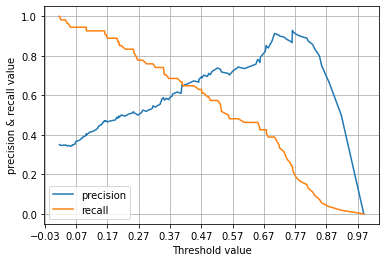

In [17]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

In [18]:
diabetes_data.describe() # min 이 0 인 애들 체크해 보자 (PREGNANCIES 제외)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


(array([  5.,   0.,   4.,  32., 156., 211., 163.,  95.,  56.,  46.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 &lt;a list of 10 Patch objects&gt;)

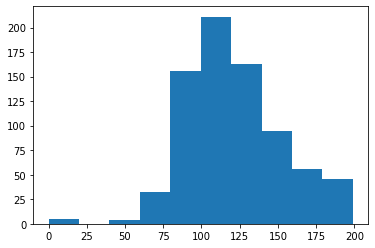

In [19]:
plt.hist(diabetes_data["Glucose"], bins = 10)

In [20]:
zero_features = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

for feature in zero_features:
    print(format(diabetes_data[diabetes_data[feature] == 0][feature].count()/diabetes_data[feature].count() * 100, ".2f"), "%")
#   0 인 값의 퍼센트가 크다

0.65 %
4.56 %
29.56 %
48.70 %
1.43 %


In [21]:
diabetes_data[zero_features] = diabetes_data[zero_features].replace(0, diabetes_data[zero_features].mean())
diabetes_data.head(5)
# 각각 평균값으로 대체해주기


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.000000,79.799479,33.6,0.627,50,1
1,1,85.0,66.0,29.000000,79.799479,26.6,0.351,31,0
2,8,183.0,64.0,20.536458,79.799479,23.3,0.672,32,1
3,1,89.0,66.0,23.000000,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.000000,168.000000,43.1,2.288,33,1


In [22]:
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 156, stratify = y)

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)

get_clf_eval(y_test, pred, pred_proba[:, 1])


auccracy: 0.799, precision: 0.767, recall: 0.611, f1: 0.680, roc_auc: 0.843


In [23]:
binarizer = Binarizer(threshold= 0.48)

get_clf_eval(y_test, binarizer.fit_transform(pred_proba[:, 1].reshape(-1, 1)), pred_proba[:, -1])

auccracy: 0.799, precision: 0.745, recall: 0.648, f1: 0.693, roc_auc: 0.843
